# Project 14 : 주식 예측에 도전해 보자 

## Step1. 시계열 데이터 준비 
* 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
* 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있음
* 우리는 종가(Close)만 사용(주식 시장은 정해진 시간 동안만 거래가 가능, 종가란 하루의 장이 마감하였을 때의 가격)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

In [2]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [3]:
from statsmodels.tsa.stattools import adfuller
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

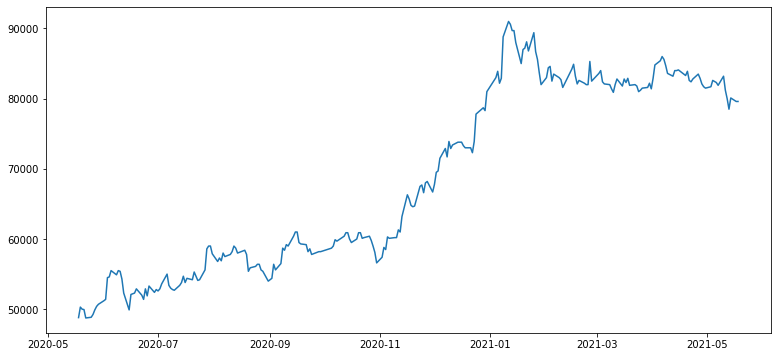

In [4]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6   

plt.plot(ts)

In [5]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


* `ts 시계열`이 안정적이지 않다는 귀무가설은 `p-value`가 거의 1에 가깝게 나타났음. 1에 가깝다는 것이 "주어진 시계열 데이터가 안정적이지 않다"는 귀무가설이 옳다는 직접적인 증거는 아니지만 귀무가설을 기각할 수 없게 되었기 때문에 이 시계열은 안정적인 시계열이라고 말할 수는 없음. 

## Step2. 각종 전처리 수행

### 2.1 결측치 처리 

In [6]:
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

* 결측치는 없음

### 2.2 로그 변환

In [7]:
ts_log = np.log(ts)

Text(0.5, 1.0, 'After log transformation')

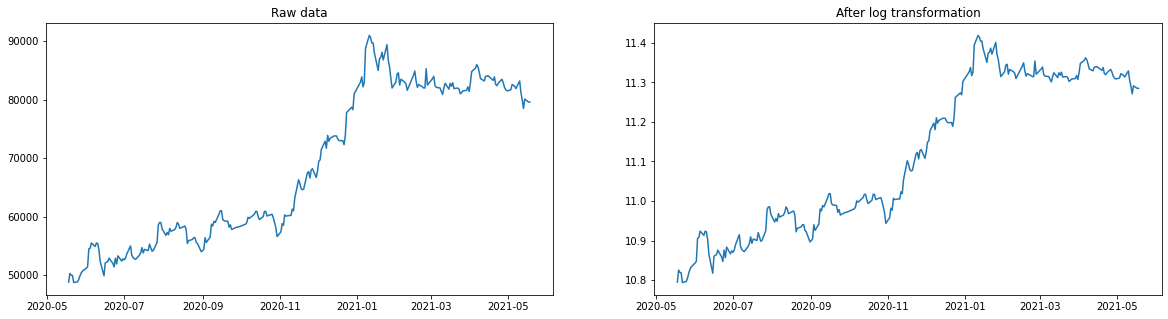

In [8]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(ts)
plt.title("Raw data")

plt.subplot(1, 2, 2)
plt.plot(ts_log)
plt.title("After log transformation")

In [9]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


* p-value가 로그변환 후에 0.1정도 떨어짐

### 2.3 Moving average 제거 - 추세(Trend) 상쇄하기

__이동평균(Moving Average, MA)이란?__ 

수의 집합에서 특정 크기의 부분 집합을 연속적으로 이동하며 산출한 평균. 이동평균법을 통해 산출된 이동편균선은 가격, 지수 등의 수치의 변화를 관찰하고 분석할 때, 전반적인 변화 흐름 파악을 용이하게 함. 

시계열 분석에서 시간 추이에 따라 나타나는 평균값 변화를 추세(trend)라고 함. 
이 변화량을 제거하려면 Moving Average(rolling mean)을 구하고 ts_log에서 빼면 됨.

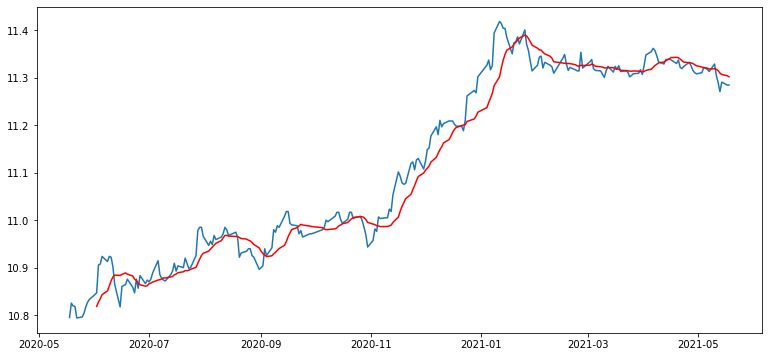

In [10]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [11]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
2020-05-25         NaN
2020-05-26         NaN
2020-05-27         NaN
2020-05-28         NaN
2020-05-29         NaN
2020-06-01         NaN
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
Name: Close, dtype: float64

* Moving Average 계산 시 (windows size=12인 경우) 앞의 10개의 데이터는 Moving Average가 계산되지 않으므로 ts_log_moving_avg에 결측치(NaN)가 발생하기 때문에 제거. 

In [12]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
2020-06-15   -0.066141
2020-06-16   -0.025267
2020-06-17   -0.024961
2020-06-18   -0.024494
2020-06-19   -0.010603
2020-06-22   -0.023697
Name: Close, dtype: float64

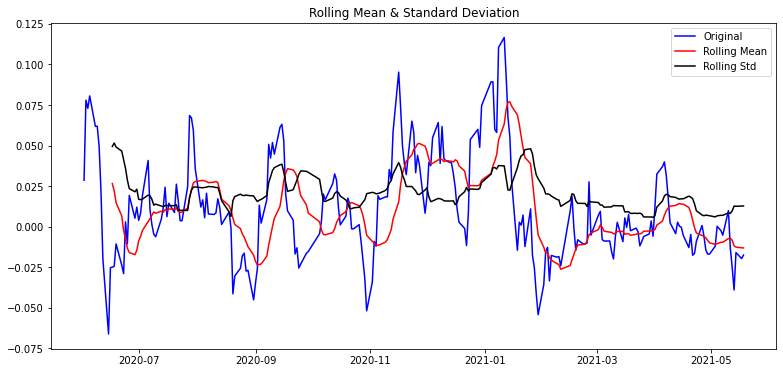

In [13]:
plot_rolling_statistics(ts_log_moving_avg)

In [14]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.163469
p-value                          0.000759
#Lags Used                       0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


* `p-value`값이 0.0008정도로 95% 이상의 confidence로 이 time siries는 stationary하다고 할 수 있음. 

#### window를 변경해보자. 

In [15]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

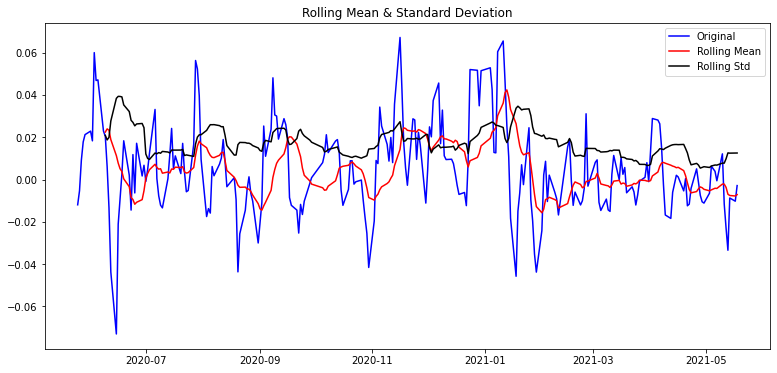

In [16]:
plot_rolling_statistics(ts_log_moving_avg_6)

In [17]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                  -4.800754
p-value                          0.000054
#Lags Used                       5.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


* `window = 6`의 경우에도 안정적인 시계열로 보임

### 2.4  차분(Differencing) - 계절성(Seasonality) 상쇄하기


Trend에는 잡히지 않지만 패턴이 파악되지 않은 주기적 변화는 예측에 방해가 되는 요소이고 이것은 MA 제거로는 상쇄되지 않는 효과임. 이런 계절적, 주기적 패턴을 계절성(Seasonality)라고 함. 

이런 패턴을 상쇄하기 위해 효과적인 방법에는 시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법인 차분(Differencing)이 있음. 이렇게 되면 남은 것은 현재 스텝 값 - 직전 스텝 값이 되어 정확히 이번 스텝에서 발생한 변화량을 의미하게 됨. 

Text(0.5, 1.0, 'Original Time Series - Shift Time Series')

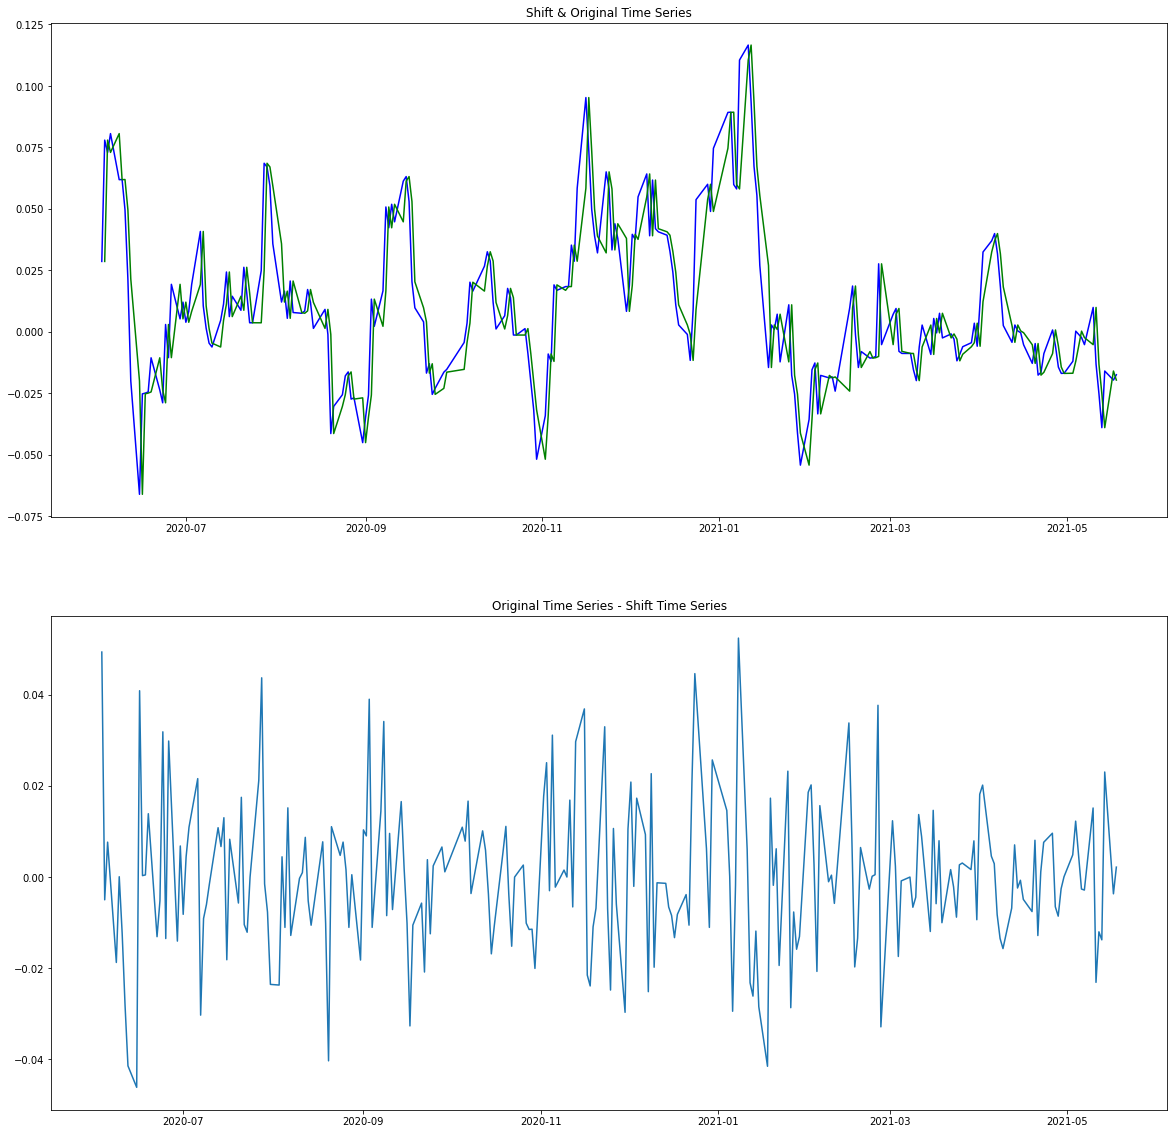

In [18]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')
plt.title('Shift & Original Time Series')

plt.subplot(2, 1, 2)
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)
plt.title("Original Time Series - Shift Time Series")

## STEP3. 시계열 안정성 분석
### 3.1 정성적 그래프 분석

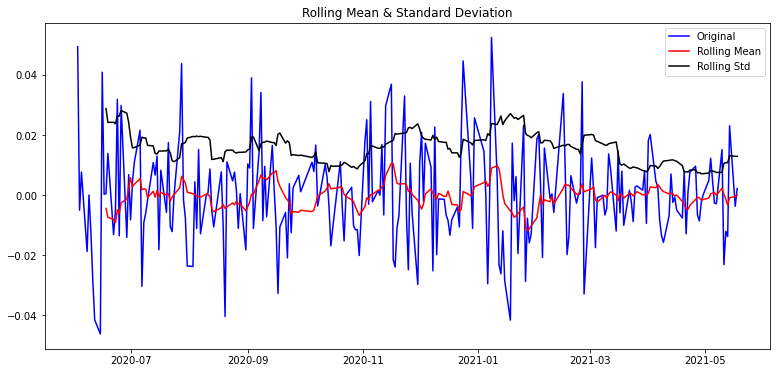

In [19]:
plot_rolling_statistics(ts_log_moving_avg_diff)

### 3.2 정량적 Augmented Dicky-Fuller Test

In [20]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.546028e+01
p-value                        2.711476e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


* 차분으로 `p-value` 값이 0.00001228842 로 줄어듦. 

### 3.3 시계열 분해 (Time Series Decomposition)

* 추세(Trend) : 장기적으로 나타나는 변동 패턴
* 계절성 (Seasonal) : 주, 월, 분기, 반기 단위 등 이미 알려진 시간의 주기로 나타나는 패턴
* 주기 (Cyclic) : 고정된 기간이 아닌 장기적인 변동
* 랜덤 요소 

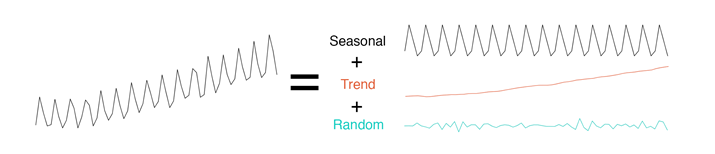

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

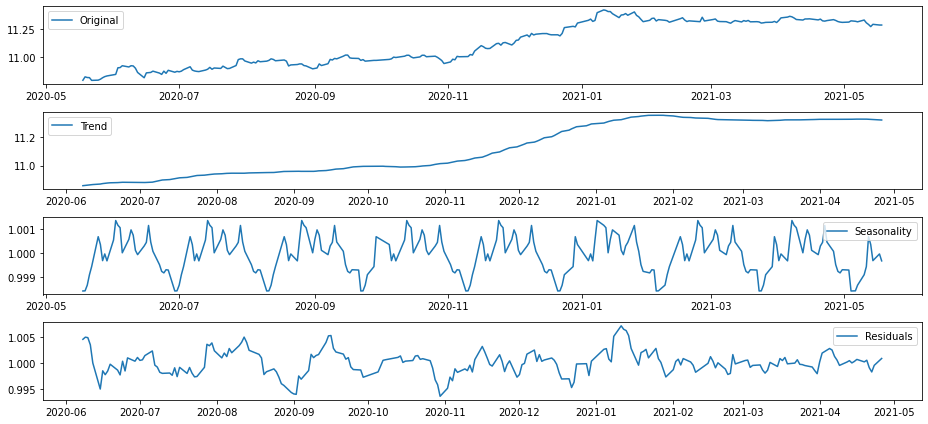

In [22]:
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 3.4 Residual 안전성 확인 

In [23]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


## STEP 4. 학습, 테스트 데이터셋 생성

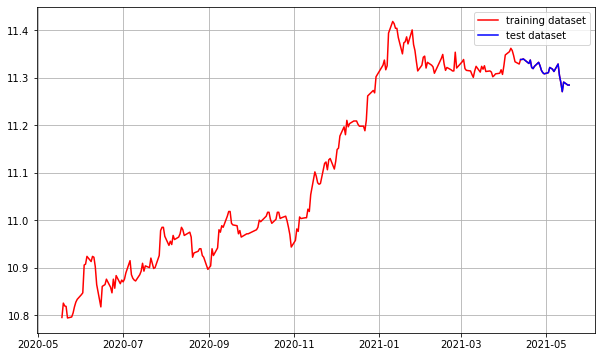

In [29]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5. 적정 ARIMA 모수 찾기

* 자기 상관 함수 (ACF, AutoCorrelation Function)

  : k시간 단위로 구분된 시계열의 관측치 간 상관 관계 함수(k가 1, 2, 3, ... 일 때, k단계 떨어진 데이터 점 상 간들의 상관 관계를 의미)
* 부분 자기 상관 함수 (PACF, PartialAutoCorrelation Function)

  : 시계열 관측치 간 상관 관계 함수(시차 k에서 k단계만큼 떨어져 있는 모든 데이터 점들 간의 상관관계를 의미)

### 5.1 ACF, PACF 그려보기 -> p,q 구하기

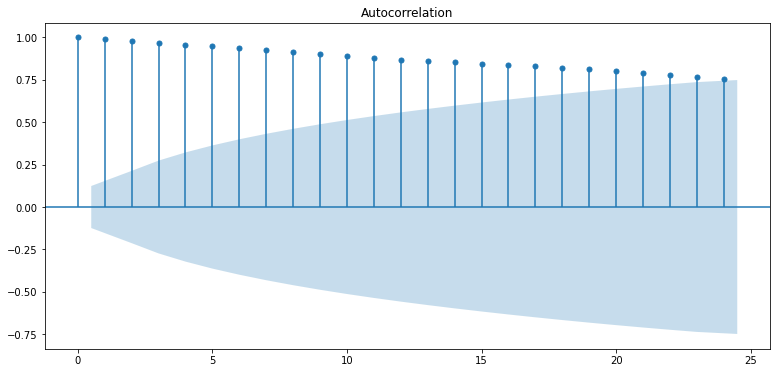

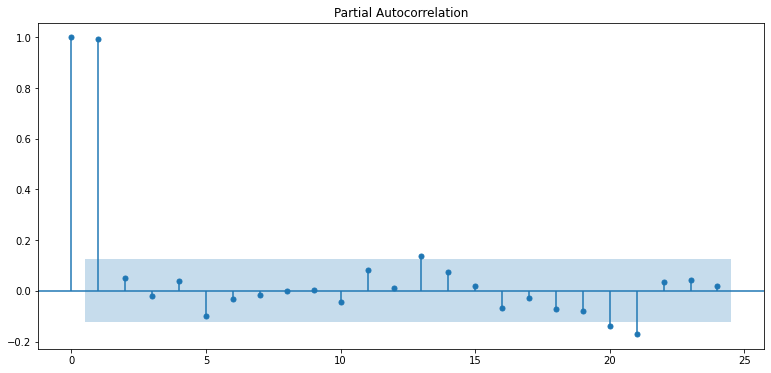

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


* `ACF`, `PACF` 그래프를 보면 `p = 1`, `q = 0`으로 둬도 될 것 같음. 

### 5.2 차분 안정성 확인 -> d 구하기

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


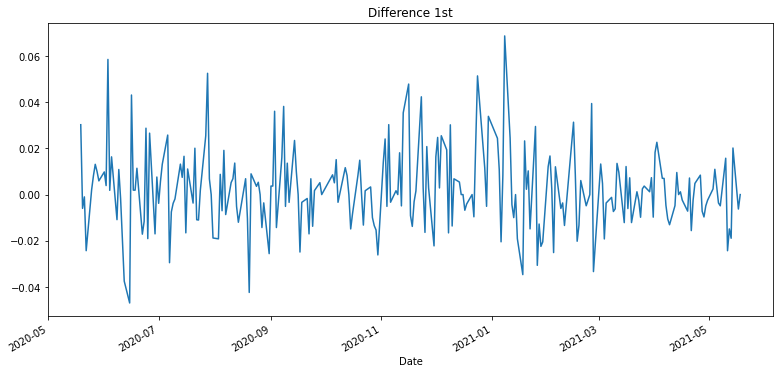

In [33]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)


Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


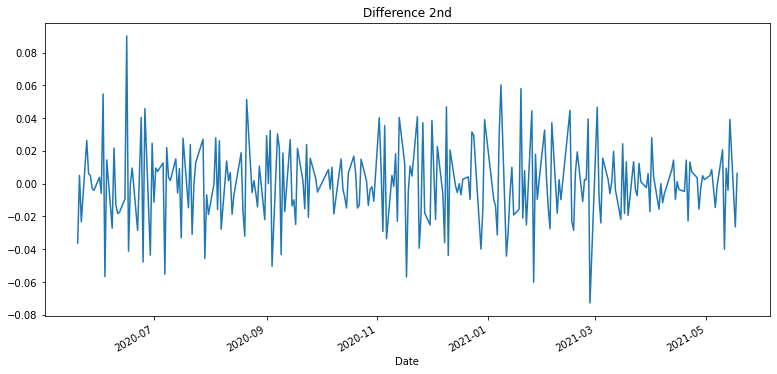

In [27]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

* `d=1`로 설정해도 괜찮을 것 같음. 

## STEP 6. ARIMA 모델 훈련과 테스트

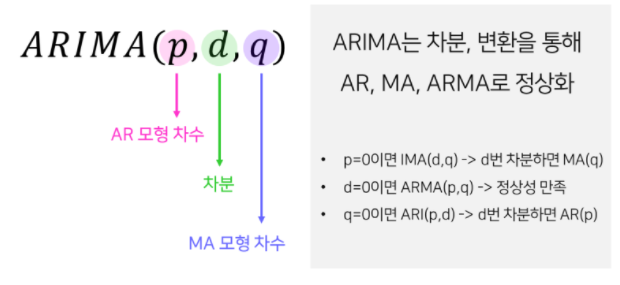

### 6.1 ARIMA 모델 빌드와 훈련

In [ ]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA', FutureWarning)

In [35]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Tue, 07 Sep 2021   AIC                          -1164.792
Time:                        02:17:27   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

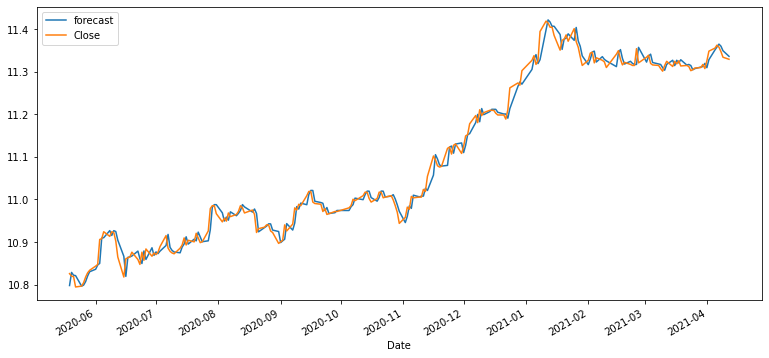

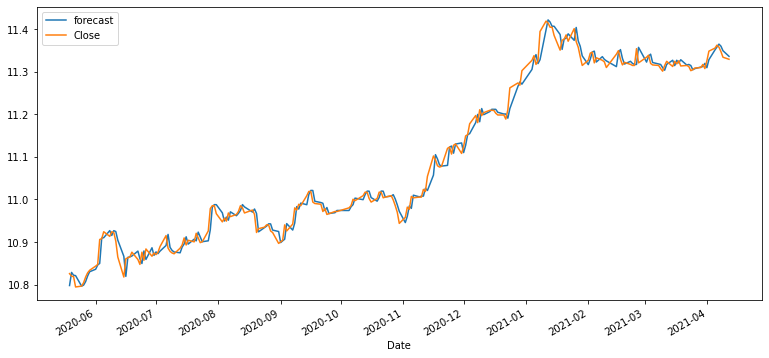

In [ ]:
fitted_m.plot_predict()

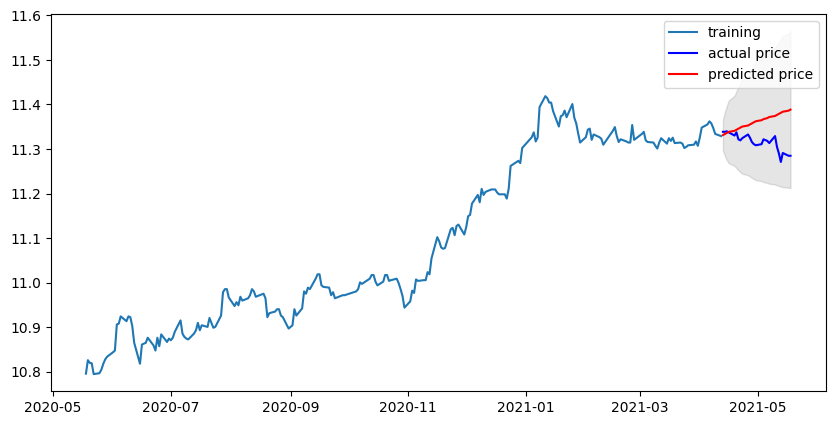

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


## STEP 7. 다른 주식 종목 예측해 보기
### 7.1 카카오

In [ ]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/035720.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-07    78400.0
2020-09-08    78000.0
2020-09-09    76800.0
2020-09-10    77100.0
2020-09-11    75800.0
Name: Close, dtype: float64

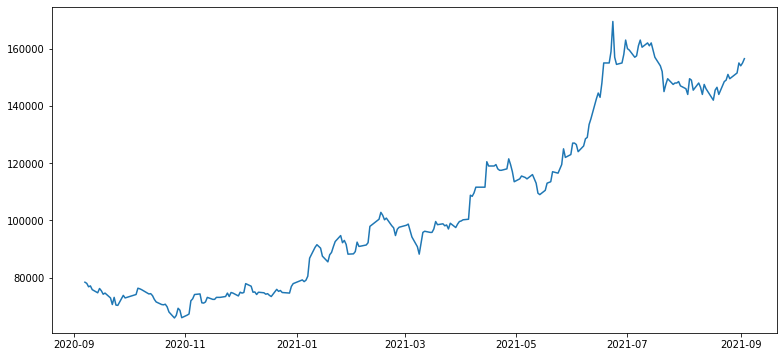

In [ ]:
rcParams['figure.figsize'] = 13, 6   

plt.plot(ts)

In [ ]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                   0.136453
p-value                          0.968464
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


In [ ]:
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

In [ ]:
ts_log = np.log(ts)

Text(0.5, 1.0, 'After log transformation')

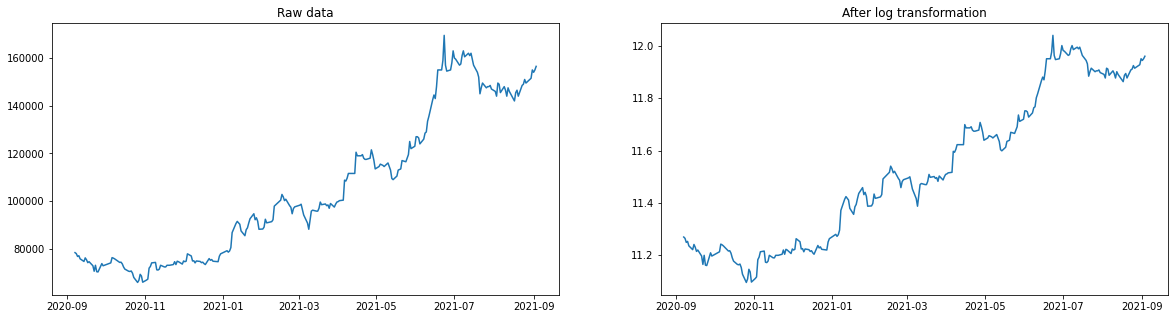

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(ts)
plt.title("Raw data")

plt.subplot(1, 2, 2)
plt.plot(ts_log)
plt.title("After log transformation")

In [ ]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   0.007583
p-value                          0.959155
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


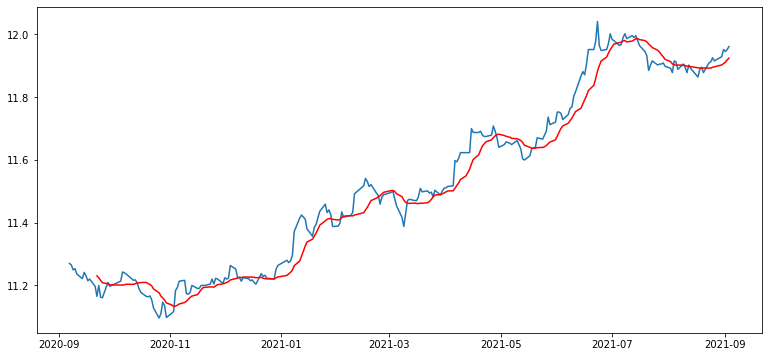

In [ ]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [ ]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2020-09-22   -0.065271
2020-09-23   -0.024640
2020-09-24   -0.053732
2020-09-25   -0.047784
2020-09-28    0.004449
2020-09-29   -0.004571
2020-10-05    0.012428
2020-10-06    0.041576
2020-10-07    0.038182
2020-10-08    0.032454
2020-10-12    0.012802
2020-10-13    0.012450
2020-10-14   -0.000584
2020-10-15   -0.017579
2020-10-16   -0.031380
Name: Close, dtype: float64

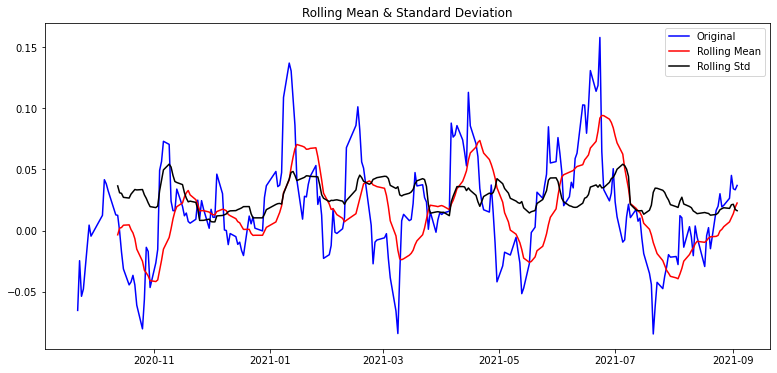

In [ ]:
plot_rolling_statistics(ts_log_moving_avg)

In [ ]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.327816
p-value                          0.000397
#Lags Used                       1.000000
Number of Observations Used    234.000000
Critical Value (1%)             -3.458608
Critical Value (5%)             -2.873972
Critical Value (10%)            -2.573396
dtype: float64


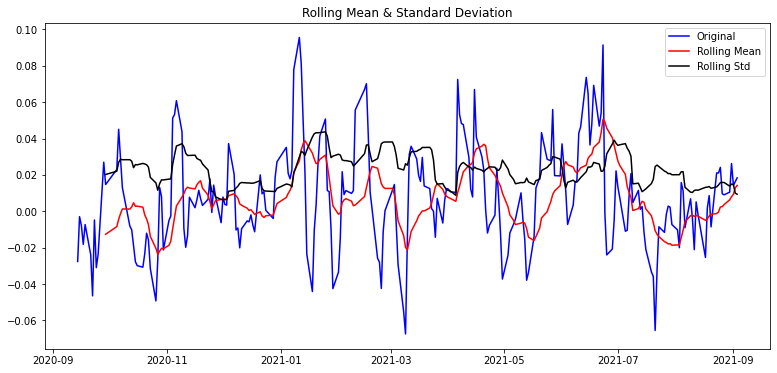

In [ ]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

plot_rolling_statistics(ts_log_moving_avg_6)

In [ ]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                -6.828645e+00
p-value                        1.918806e-09
#Lags Used                     1.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


Text(0.5, 1.0, 'Original Time Series - Shift Time Series')

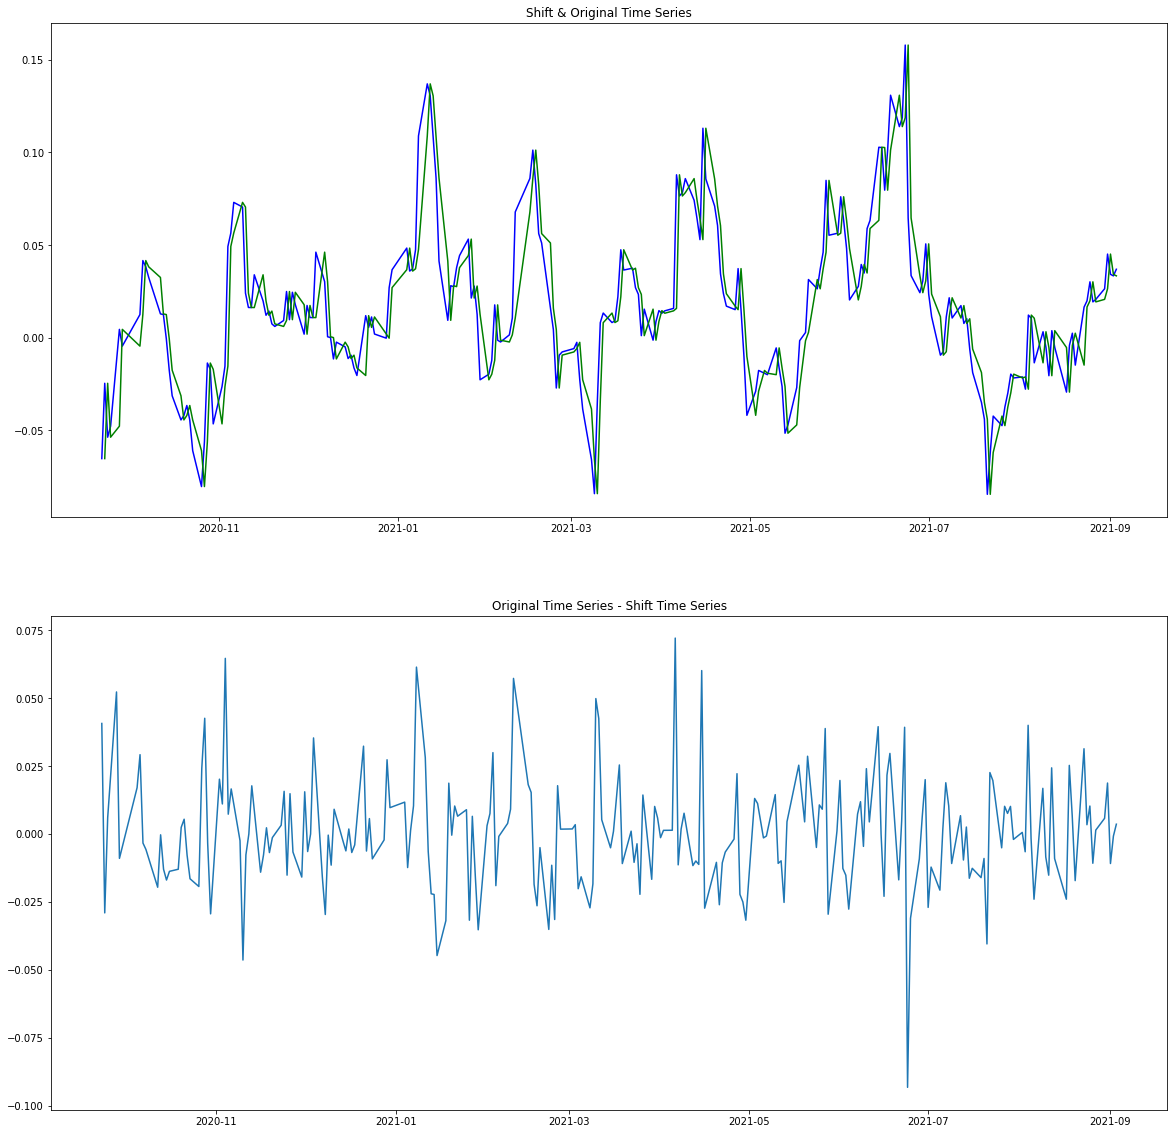

In [ ]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')
plt.title('Shift & Original Time Series')

plt.subplot(2, 1, 2)
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)
plt.title("Original Time Series - Shift Time Series")

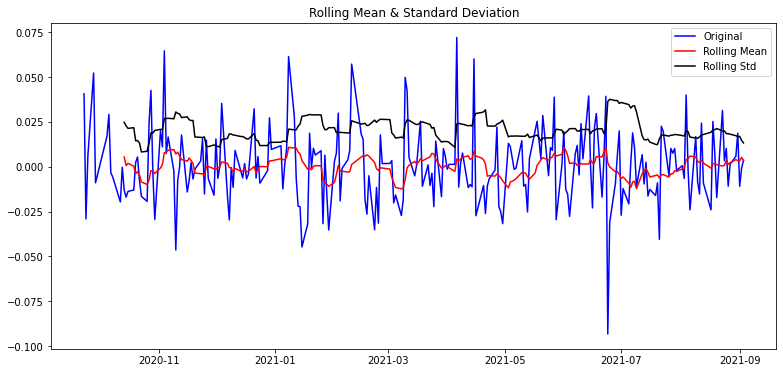

In [ ]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [ ]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.449265e+01
p-value                        6.112372e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


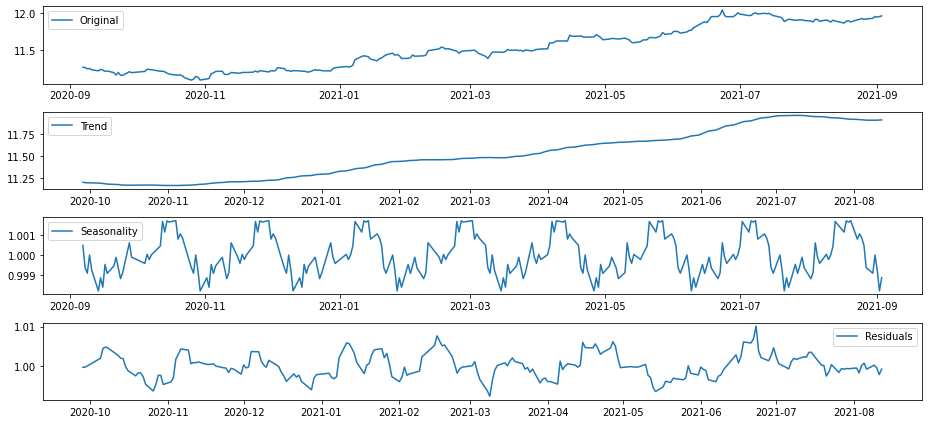

In [ ]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.243341
p-value                          0.000007
#Lags Used                       1.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64


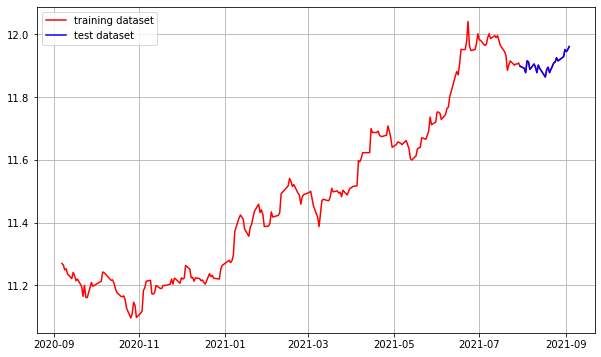

In [ ]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

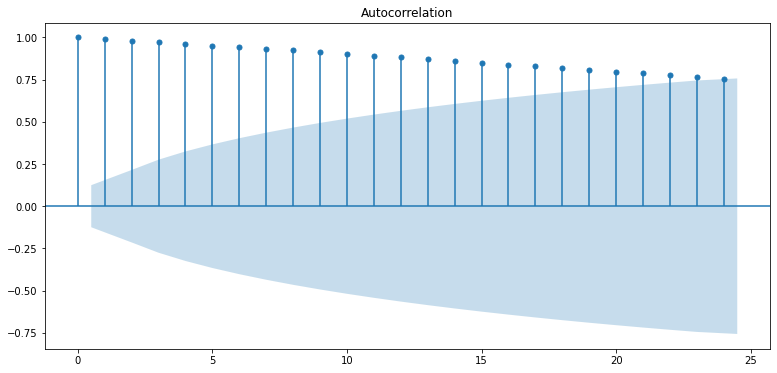

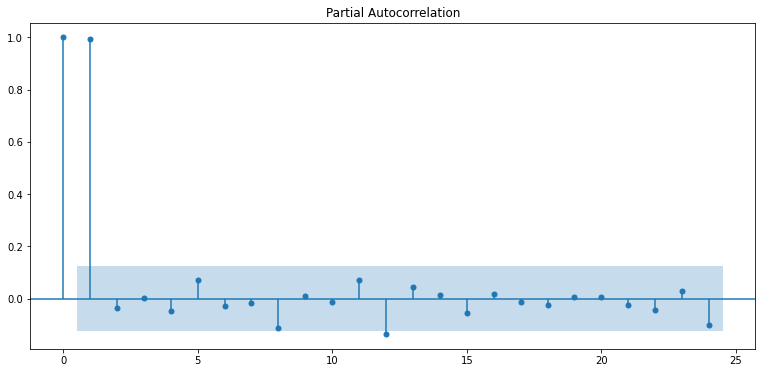

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -1.468894e+01
p-value                        3.071268e-27
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


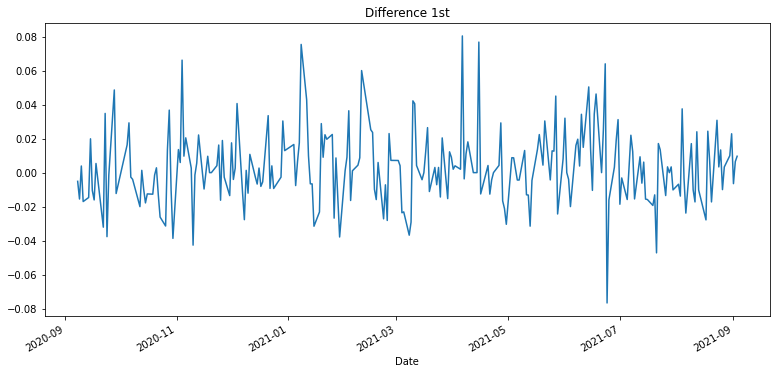

In [ ]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)


In [ ]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  221
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 527.299
Method:                       css-mle   S.D. of innovations              0.022
Date:                Mon, 06 Sep 2021   AIC                          -1048.598
Time:                        02:35:08   BIC                          -1038.403
Sample:                             1   HQIC                         -1044.481
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0029      0.002      1.767      0.077      -0.000       0.006
ar.L1.D.Close     0.0842      0.067      1.258      0.208      -0.047       0.215
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

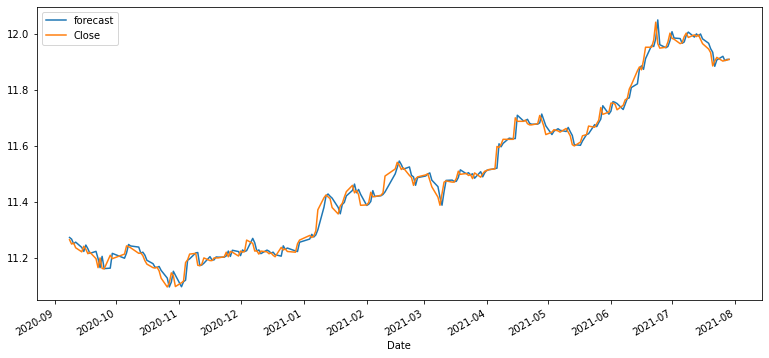

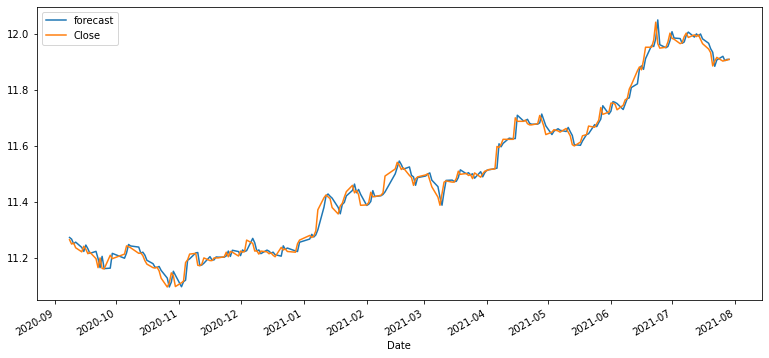

In [ ]:
fitted_m.plot_predict()

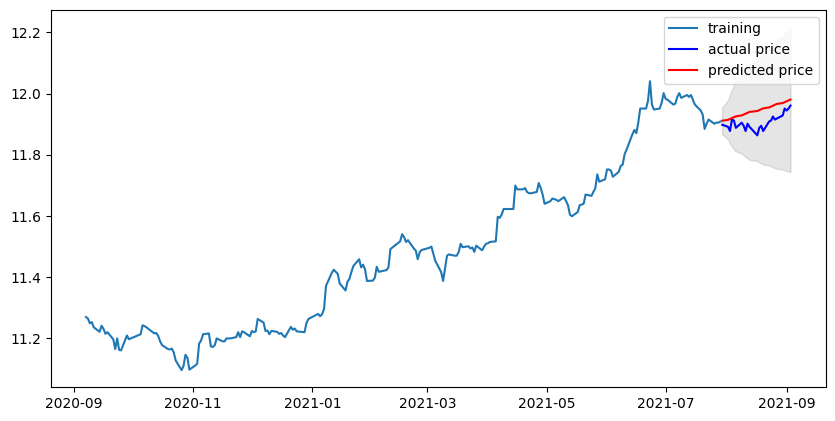

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  40640627.392147645
MAE:  5779.921836155599
RMSE:  6375.00018761942
MAPE: 3.92%


### 7.2 네이버 

In [ ]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/035420.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-07    314500.0
2020-09-08    311000.0
2020-09-09    304500.0
2020-09-10    307500.0
2020-09-11    306000.0
Name: Close, dtype: float64

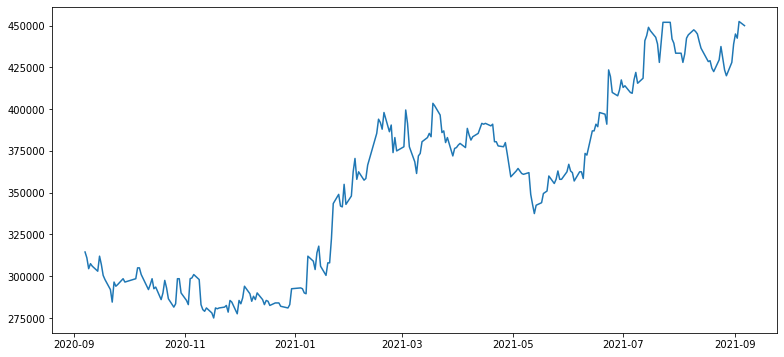

In [ ]:
rcParams['figure.figsize'] = 13, 6   

plt.plot(ts)

In [ ]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -0.438856
p-value                          0.903406
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


In [ ]:
ts=ts.interpolate(method='time')
ts[ts.isna()] 

Series([], Name: Close, dtype: float64)

Text(0.5, 1.0, 'After log transformation')

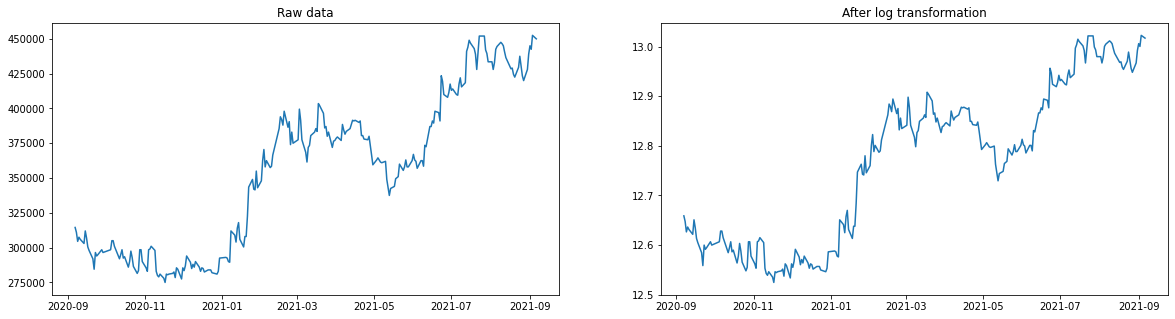

In [ ]:
ts_log = np.log(ts)

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(ts)
plt.title("Raw data")

plt.subplot(1, 2, 2)
plt.plot(ts_log)
plt.title("After log transformation")

In [ ]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.394655
p-value                          0.910987
#Lags Used                       2.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


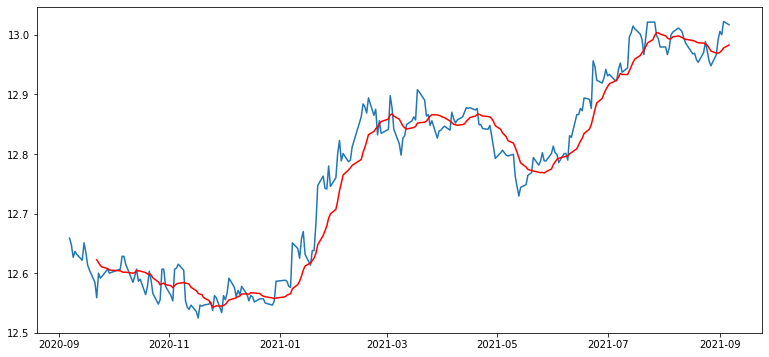

In [ ]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [ ]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2020-09-22   -0.063860
2020-09-23   -0.017635
2020-09-24   -0.021418
2020-09-25   -0.015381
2020-09-28   -0.001111
2020-09-29   -0.005205
2020-10-05    0.002764
2020-10-06    0.026197
2020-10-07    0.026742
2020-10-08    0.013402
2020-10-12   -0.015260
2020-10-13   -0.005890
2020-10-14    0.001901
2020-10-15   -0.017272
2020-10-16   -0.013717
Name: Close, dtype: float64

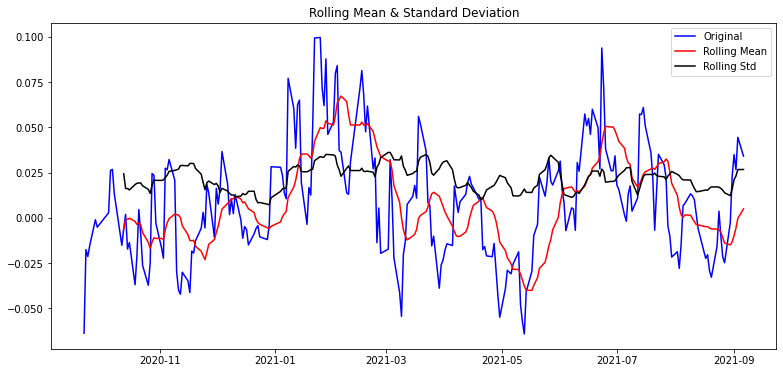

In [ ]:
plot_rolling_statistics(ts_log_moving_avg)

In [ ]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -5.114707
p-value                          0.000013
#Lags Used                       0.000000
Number of Observations Used    236.000000
Critical Value (1%)             -3.458366
Critical Value (5%)             -2.873866
Critical Value (10%)            -2.573339
dtype: float64


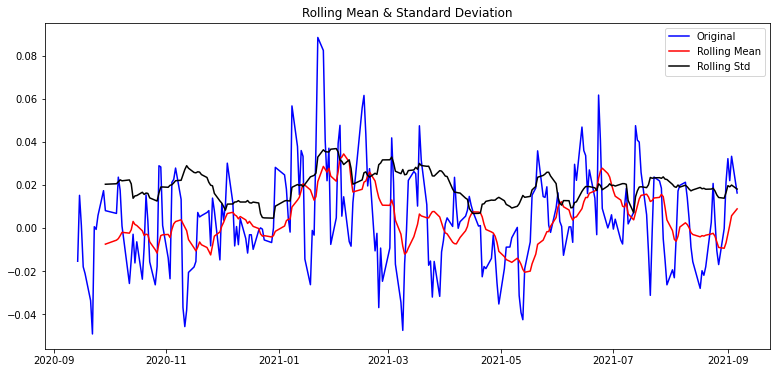

In [ ]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

plot_rolling_statistics(ts_log_moving_avg_6)

In [ ]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                -7.832185e+00
p-value                        6.250281e-12
#Lags Used                     1.000000e+00
Number of Observations Used    2.410000e+02
Critical Value (1%)           -3.457779e+00
Critical Value (5%)           -2.873609e+00
Critical Value (10%)          -2.573202e+00
dtype: float64


Text(0.5, 1.0, 'Original Time Series - Shift Time Series')

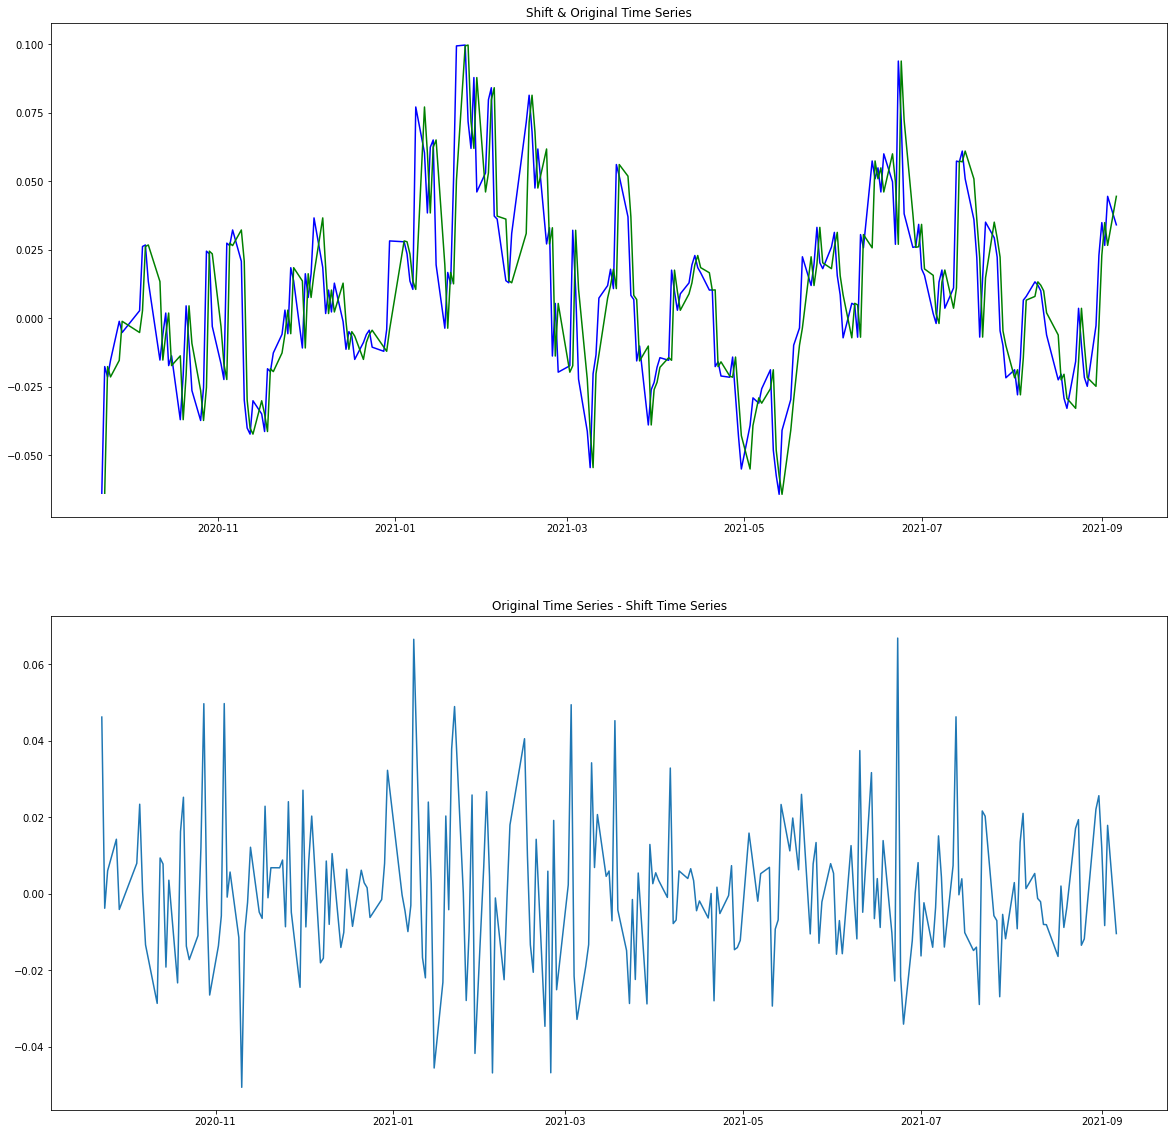

In [ ]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')
plt.title('Shift & Original Time Series')

plt.subplot(2, 1, 2)
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)
plt.title("Original Time Series - Shift Time Series")

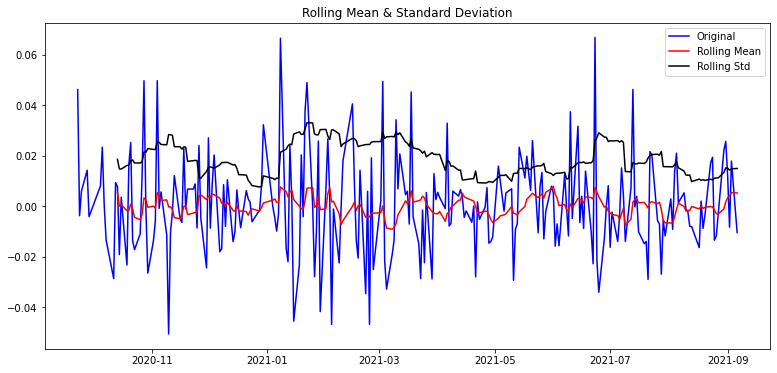

In [ ]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [ ]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -6.028623e+00
p-value                        1.435752e-07
#Lags Used                     1.400000e+01
Number of Observations Used    2.210000e+02
Critical Value (1%)           -3.460291e+00
Critical Value (5%)           -2.874709e+00
Critical Value (10%)          -2.573789e+00
dtype: float64


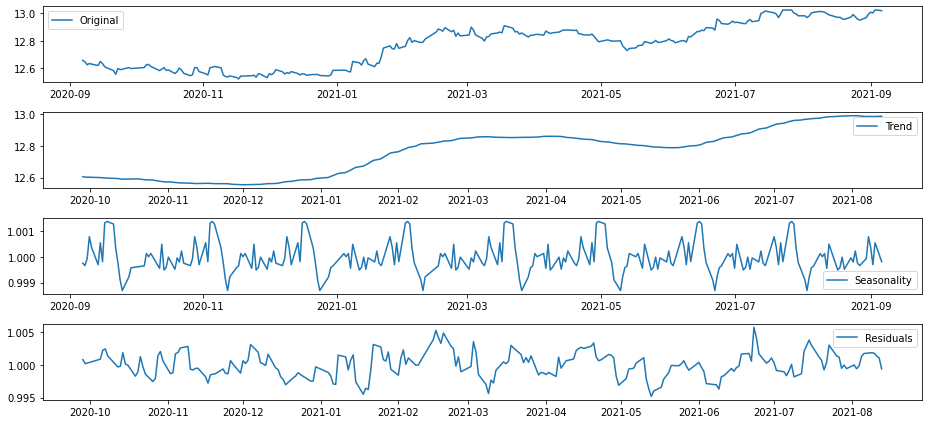

In [ ]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.629110e+00
p-value                        5.774999e-09
#Lags Used                     1.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


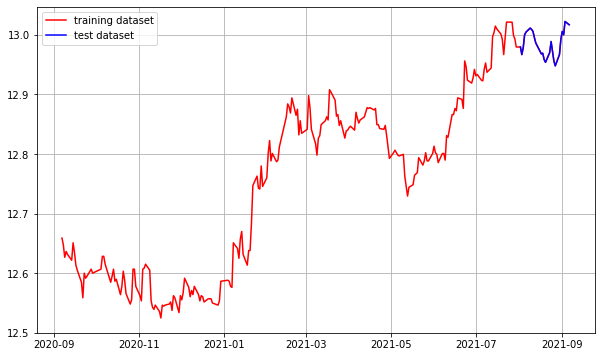

In [ ]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

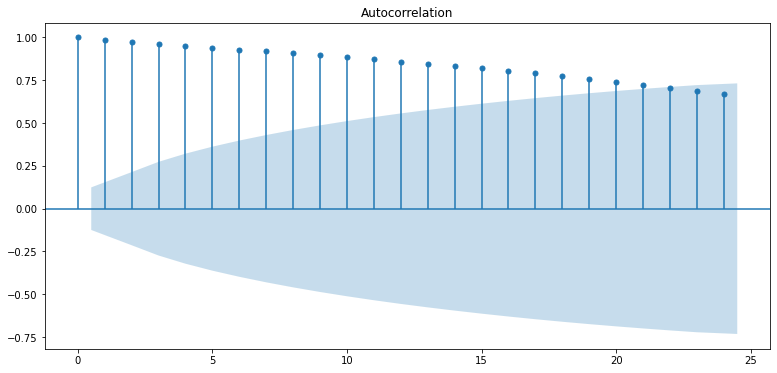

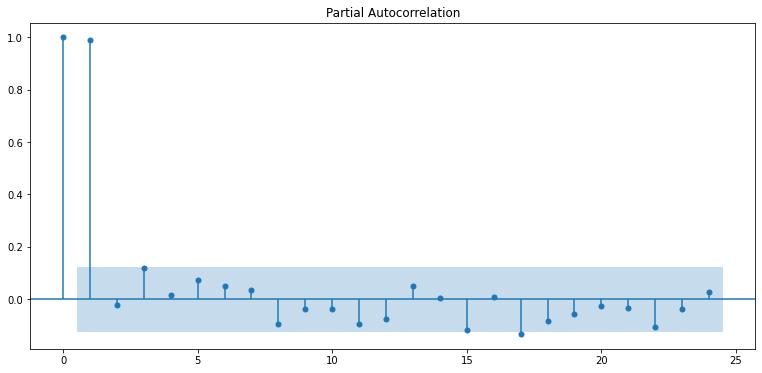

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.270321e+01
p-value                        1.068771e-23
#Lags Used                     1.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


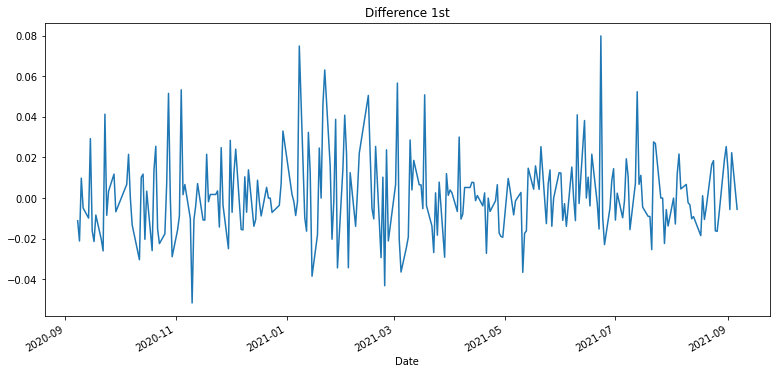

In [ ]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [ ]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 545.646
Method:                       css-mle   S.D. of innovations              0.021
Date:                Mon, 06 Sep 2021   AIC                          -1085.292
Time:                        02:38:39   BIC                          -1075.084
Sample:                             1   HQIC                         -1081.170
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0014      0.001      1.072      0.284      -0.001       0.004
ar.L1.D.Close    -0.0285      0.067     -0.426      0.670      -0.160       0.103
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

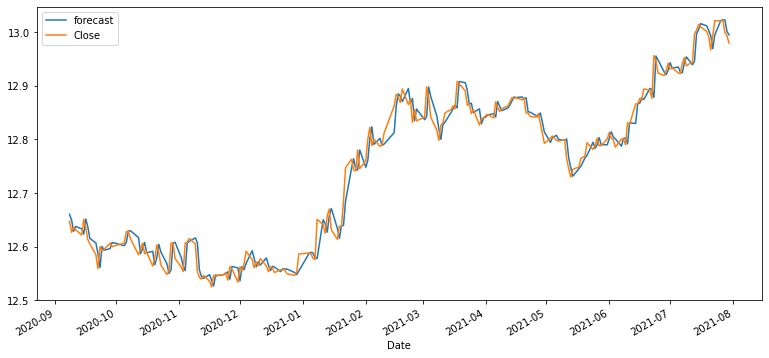

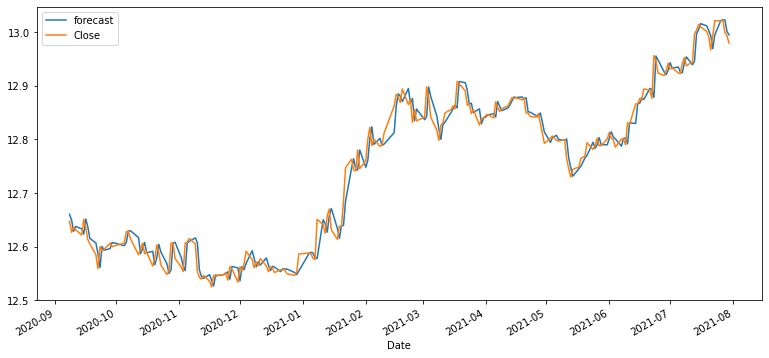

In [ ]:
fitted_m.plot_predict()

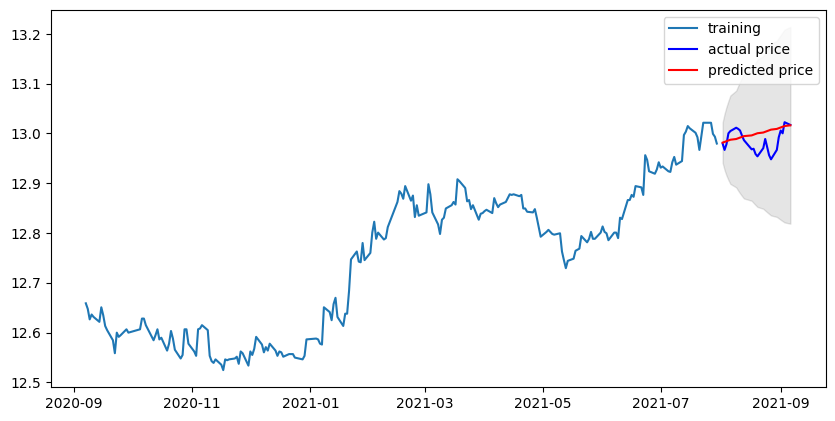

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  136007680.91523317
MAE:  9438.72225928755
RMSE:  11662.233101564776
MAPE: 2.19%


### 7.3 Google

In [ ]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/GOOG.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-09-08    1532.390015
2020-09-09    1556.959961
2020-09-10    1532.020020
2020-09-11    1520.719971
2020-09-14    1519.280029
Name: Close, dtype: float64

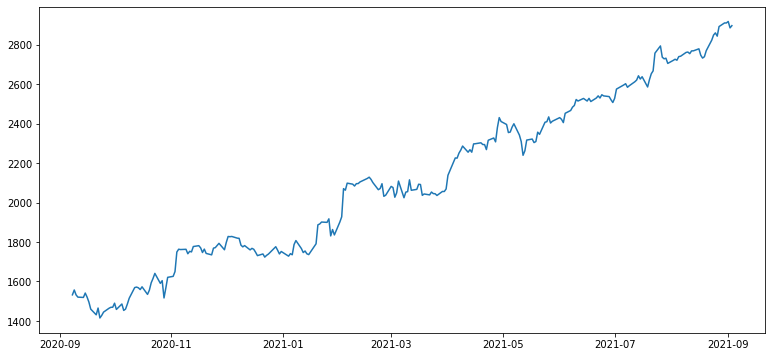

In [ ]:
rcParams['figure.figsize'] = 13, 6   

plt.plot(ts)

In [ ]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                   0.432960
p-value                          0.982687
#Lags Used                       5.000000
Number of Observations Used    245.000000
Critical Value (1%)             -3.457326
Critical Value (5%)             -2.873410
Critical Value (10%)            -2.573096
dtype: float64


In [ ]:
ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

Text(0.5, 1.0, 'After log transformation')

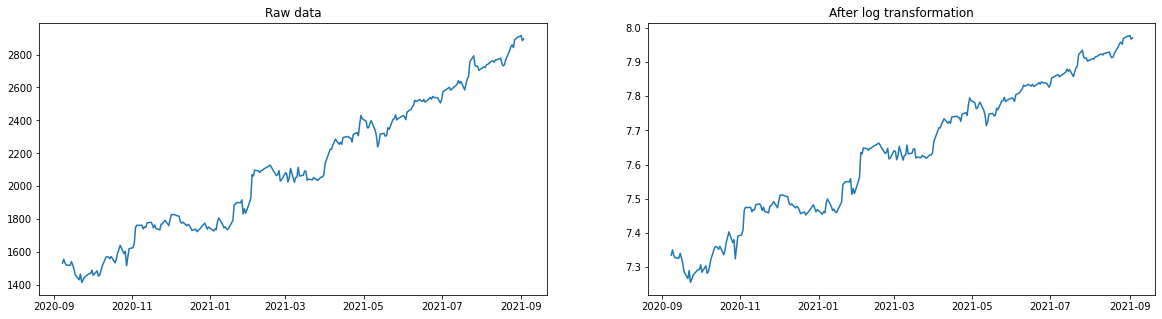

In [ ]:
ts_log = np.log(ts)

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(ts)
plt.title("Raw data")

plt.subplot(1, 2, 2)
plt.plot(ts_log)
plt.title("After log transformation")

In [ ]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.460093
p-value                          0.899572
#Lags Used                       7.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


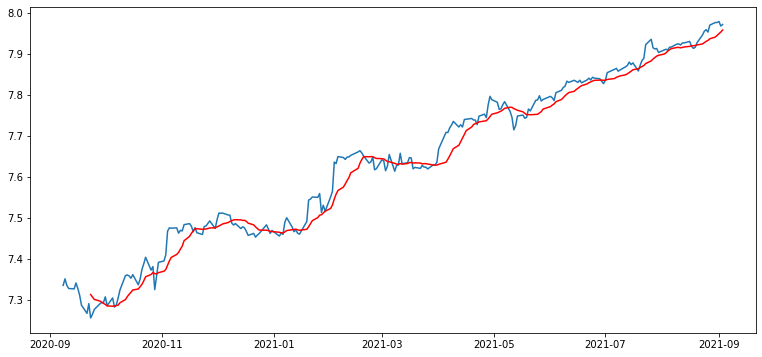

In [ ]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [ ]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2020-09-23   -0.057258
2020-09-24   -0.042196
2020-09-25   -0.024371
2020-09-28   -0.007170
2020-09-29   -0.001026
2020-09-30    0.001928
2020-10-01    0.018598
2020-10-02    0.000611
2020-10-05    0.019890
2020-10-06   -0.001904
2020-10-07    0.001119
2020-10-08    0.017369
2020-10-09    0.031199
2020-10-12    0.058334
2020-10-13    0.052940
Name: Close, dtype: float64

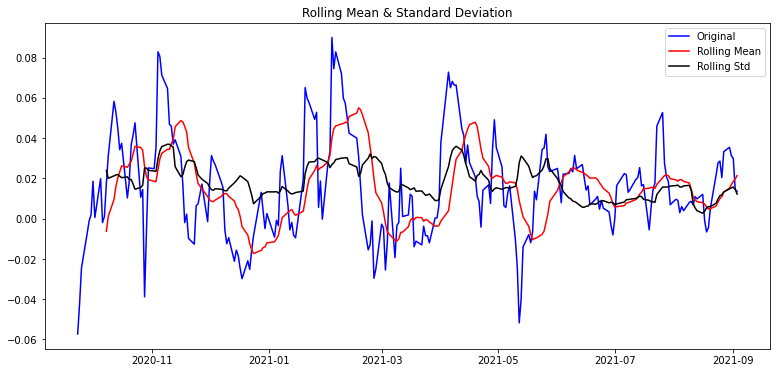

In [ ]:
plot_rolling_statistics(ts_log_moving_avg)

In [ ]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.578541
p-value                          0.000141
#Lags Used                       7.000000
Number of Observations Used    232.000000
Critical Value (1%)             -3.458855
Critical Value (5%)             -2.874080
Critical Value (10%)            -2.573453
dtype: float64


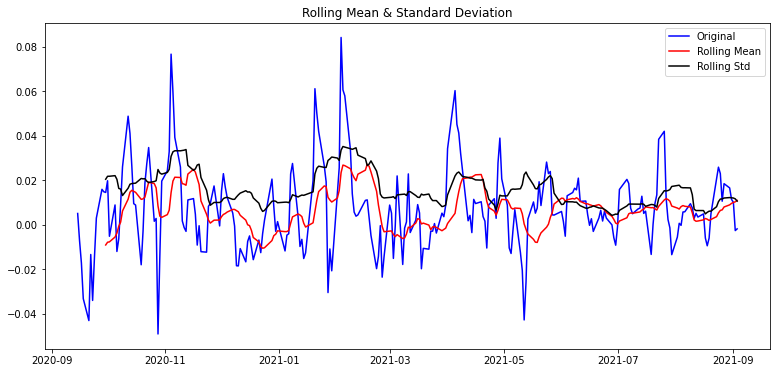

In [ ]:
moving_avg_6 = ts_log.rolling(window=6).mean()
ts_log_moving_avg_6 = ts_log - moving_avg_6
ts_log_moving_avg_6.dropna(inplace=True)

plot_rolling_statistics(ts_log_moving_avg_6)

In [ ]:
augmented_dickey_fuller_test(ts_log_moving_avg_6)

Results of Dickey-Fuller Test:
Test Statistic                  -5.344162
p-value                          0.000004
#Lags Used                       7.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


Text(0.5, 1.0, 'Original Time Series - Shift Time Series')

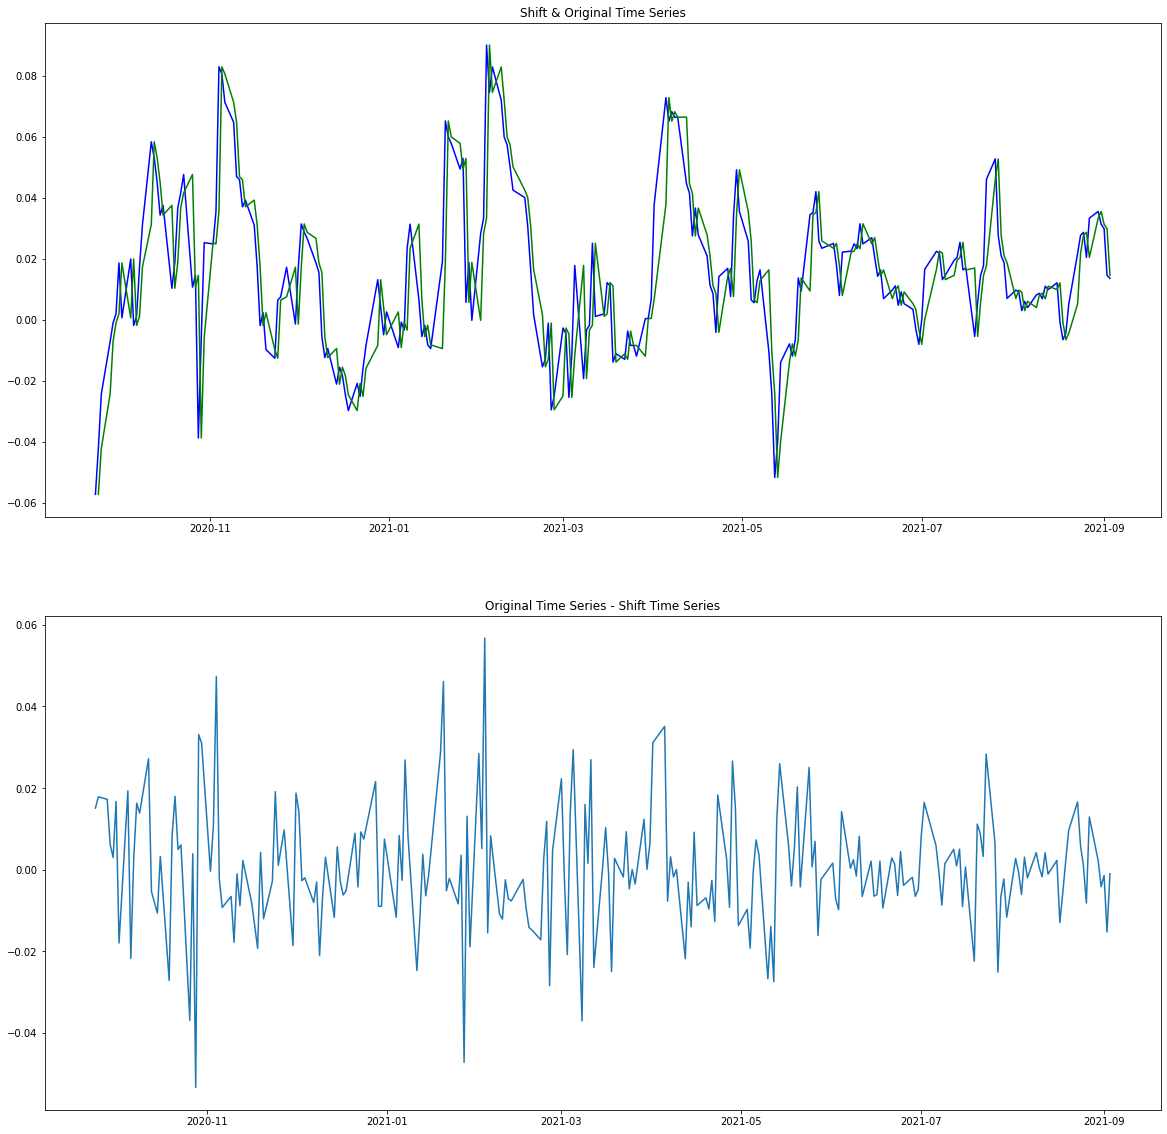

In [ ]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')
plt.title('Shift & Original Time Series')

plt.subplot(2, 1, 2)
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)
plt.title("Original Time Series - Shift Time Series")

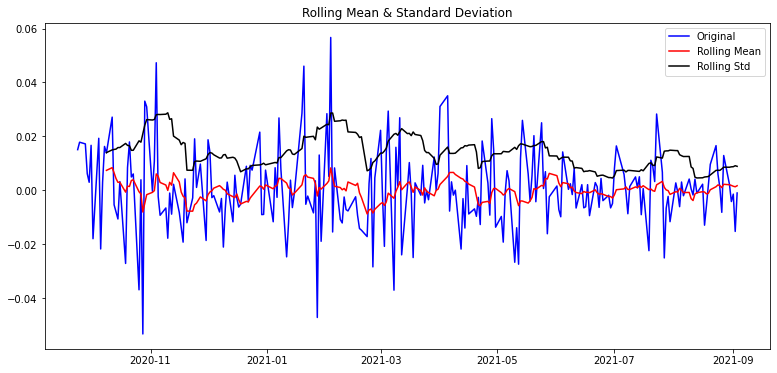

In [ ]:
plot_rolling_statistics(ts_log_moving_avg_diff)

In [ ]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -7.354147e+00
p-value                        9.881188e-11
#Lags Used                     1.200000e+01
Number of Observations Used    2.260000e+02
Critical Value (1%)           -3.459620e+00
Critical Value (5%)           -2.874415e+00
Critical Value (10%)          -2.573632e+00
dtype: float64


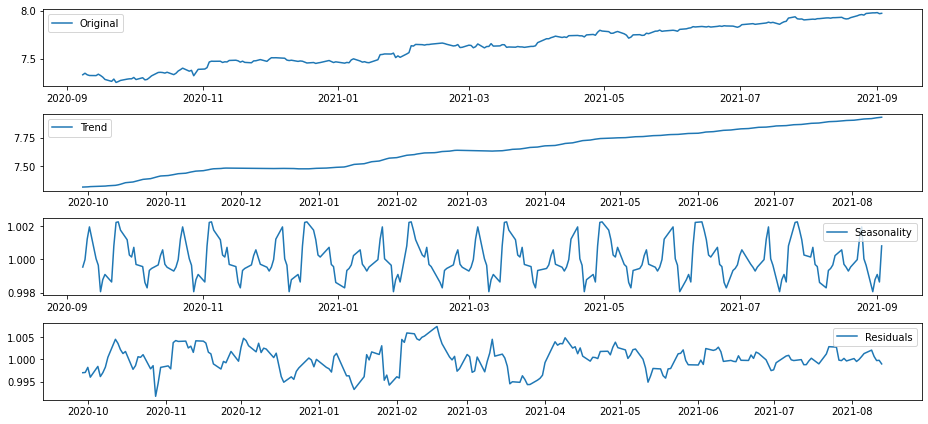

In [ ]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -2.754986
p-value                          0.064997
#Lags Used                      15.000000
Number of Observations Used    205.000000
Critical Value (1%)             -3.462658
Critical Value (5%)             -2.875744
Critical Value (10%)            -2.574341
dtype: float64


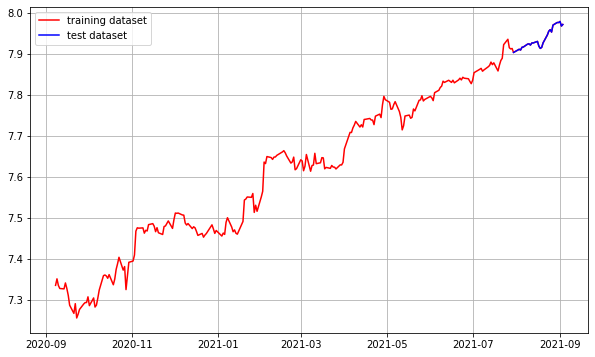

In [ ]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

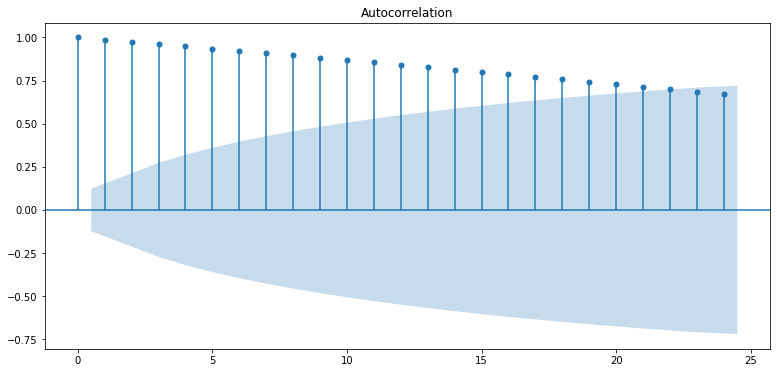

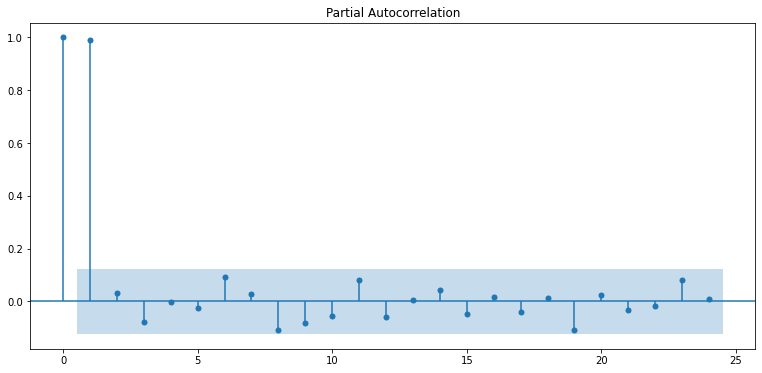

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -6.586295e+00
p-value                        7.300537e-09
#Lags Used                     6.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


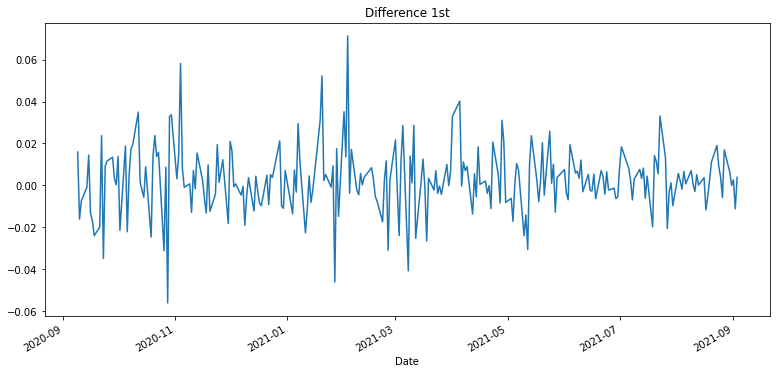

In [ ]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

In [ ]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 603.369
Method:                       css-mle   S.D. of innovations              0.016
Date:                Mon, 06 Sep 2021   AIC                          -1200.738
Time:                        02:43:15   BIC                          -1190.503
Sample:                             1   HQIC                         -1196.606
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0026      0.001      2.464      0.014       0.001       0.005
ar.L1.D.Close    -0.0455      0.067     -0.683      0.495      -0.176       0.085
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

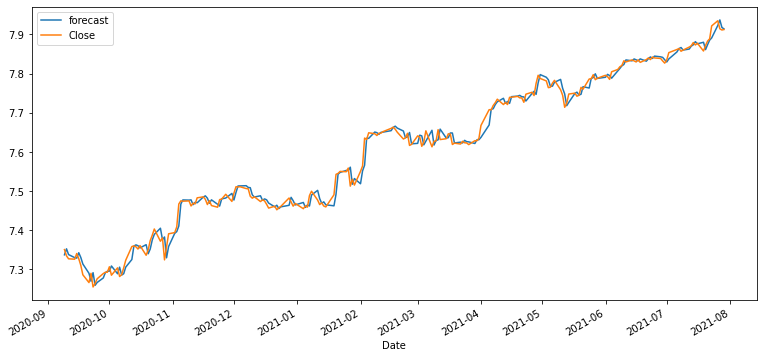

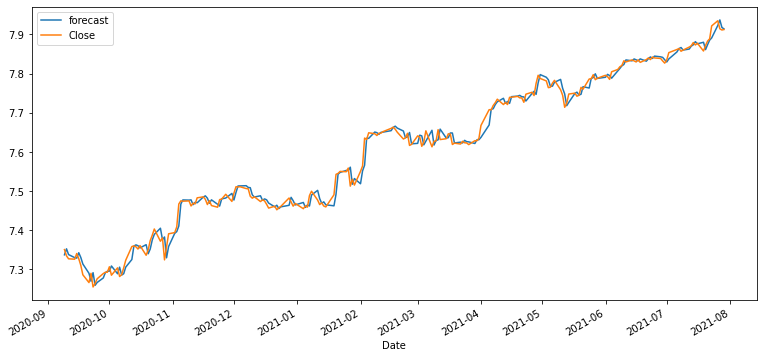

In [ ]:
fitted_m.plot_predict()

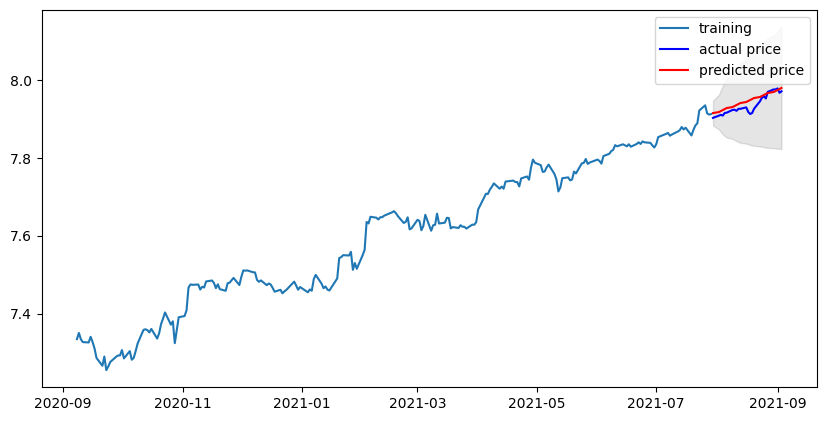

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1904.1269051311667
MAE:  35.83070718588424
RMSE:  43.63630260610042
MAPE: 1.29%


# 회고

대학교를 다닐 때, 시계열을 배우지 못한 것에 아쉬움이 있었는데 배울 수 있는 기회가 있어 좋았다. 

여러 시계열의 개념을 접했고 과거 데이터를 통해 미래를 예측한다는 것이 흥미로웠다. 

계절성, 추세, 랜덤 등을 확인하고 어떻게 해결하는지에 대해 배운 것이 좋았다. 

시계열 분석의 ARIMA 모델을 처음 접했는데, 모수를 설정하기 위해 그래프를 보고 확인하는 부분이 이해가 완벽하게 되진않았지만, 그래프를 보고 모수를 선택한다는 것이 다른 것보다 확실하게 눈에 보이는 점이 좋았다. 

새롭게 다룬 3가지 주식 데이터도 결과가 좋아서 기분이 좋은 프로젝트였다. 